In [18]:
import TensorFrost as tf
import numpy as np
import matplotlib.pyplot as plt
import time

def WaveIteration(u, v, dt):
    i,j = u.indices
    laplacian = u[i-1, j] + u[i+1, j] + u[i, j-1] + u[i, j+1] - u * 4.0
    force = laplacian - 0.01 * tf.sin(2.0*np.pi*u)
    v_new = v + dt*force
    u_new = u + dt*v_new
    return u_new, v_new

def WaveEq():
    u = tf.input([-1, -1], tf.float32)
    v = tf.input([-1, -1], tf.float32)

    u,v = WaveIteration(u, v, 0.2)

    return [u, v]

tf.initialize(tf.cpu, "H:/cl_compile.bat /O2 /fp:fast /openmp")
test = tf.program(WaveEq)


dim =  2


In [19]:
#do a few steps and measure performance by timing every 100 steps
import time
import imageio
from IPython.display import Image
import os

start = time.time()

file_path = 'H:/TestVideos/wave.gif'

#remove file if it exists

if os.path.isfile(file_path):
    os.remove(file_path)

writer = imageio.get_writer(file_path, mode='I', fps=30)

N = 512

x = np.arange(N)
y = np.arange(N)
X,Y = np.meshgrid(x, y)
Anp = np.exp(-((X-N/2)**2 + (Y-N/2+50)**2)/(10**2))
Anp += np.exp(-((X-N/2-50)**2 + (Y-N/2-50)**2)/(10**2))
Bnp = np.zeros((N, N))

A = tf.memory(Anp)
B = tf.memory(Bnp)

print("Used memory: " + str(tf.used_memory()))

iters = 20000

for i in range(iters):
    A, B = test(A, B)
    if(i % 1000 == 0):
        frame = A.numpy
        frame = np.clip(np.abs(3.0 * frame * 255), 0, 255).astype(np.uint8)
        writer.append_data(frame)
    if i % 100 == 99:
        print("Iterations per second: " + str(100/(time.time()-start)))
        start = time.time()


writer.close()

print("Used memory: " + str(tf.used_memory()))

Used memory: 524288
Iterations per second: 1204.806236732724
Iterations per second: 1639.3733779431539
Iterations per second: 1587.320521650936
Iterations per second: 1886.7764282501125
Iterations per second: 1612.9208903108704
Iterations per second: 1923.0399618537606
Iterations per second: 2127.705856093503
Iterations per second: 2173.9353982667826
Iterations per second: 2127.6734760134123
Iterations per second: 2127.597926325721
Iterations per second: 2000.0305180437933
Iterations per second: 2173.92413067478
Iterations per second: 2083.2980678488057
Iterations per second: 2083.3705041152775
Iterations per second: 1960.6972732669842
Iterations per second: 2083.380852564548
Iterations per second: 2127.7166496725463
Iterations per second: 2173.901595841173
Iterations per second: 1999.9828340096415
Iterations per second: 1694.8531759020175
Iterations per second: 1851.896135319025
Iterations per second: 2173.9579338011963
Iterations per second: 2127.66268287239
Iterations per second: 21

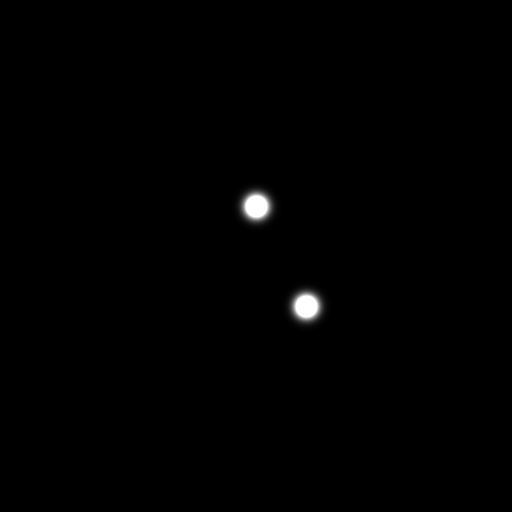

In [20]:
#display the gif
Image(filename=file_path)

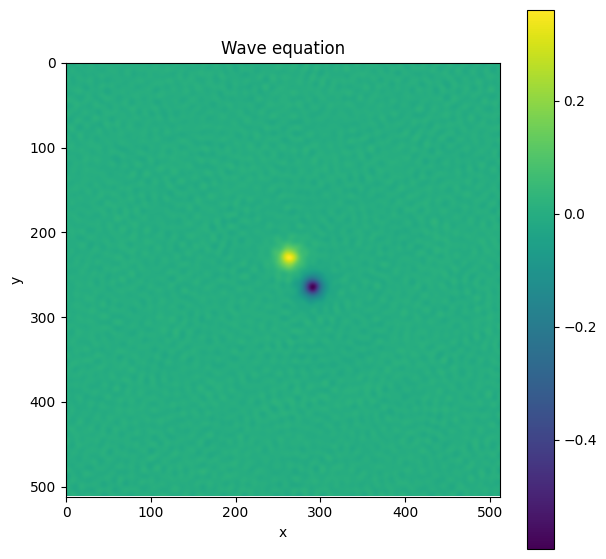

In [21]:
# Plot the results (with colorbar)
plt.figure(figsize=(7,7))
plt.imshow(A.numpy)
plt.colorbar()
plt.title("Wave equation")
plt.xlabel("x")
plt.ylabel("y")
plt.show()